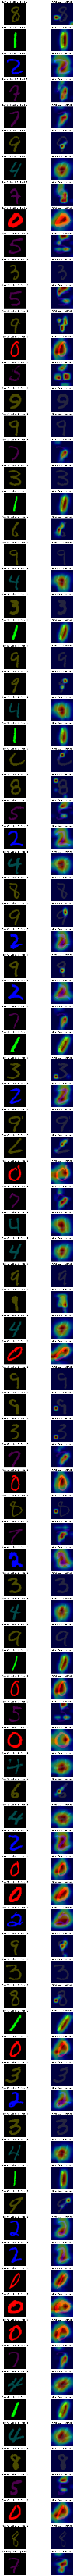

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torch.utils.data import DataLoader, TensorDataset
from IPython.display import display, HTML

# 0. Make the output cell scrollable (Kaggle/Jupyter optimization)
display(HTML("""
<style>
    .output_subarea {
        max-height: 800px;
        overflow-y: scroll !important;
    }
</style>
"""))

# 1. Define Architecture
class CNN3Layer(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN3Layer, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 3 * 3, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# 2. Setup Device and Load Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN3Layer(num_classes=10).to(device)
model.load_state_dict(torch.load('/kaggle/input/task1-v2/pytorch/default/1/task1_v2.pth', map_location=device))
model.eval()

# 3. Load Data
data = np.load('/kaggle/input/mnist-coloured-dataset/test_data_rg.npz')
X_test = data['images'].astype('float32') / 255.0
y_test = data['labels']

X_test_tensor = torch.FloatTensor(X_test).permute(0, 3, 1, 2)
y_test_tensor = torch.LongTensor(y_test)
# Set batch_size=1 to iterate image by image
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=1, shuffle=True)

# 4. Grad-CAM Implementation
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hooks = [
            target_layer.register_forward_hook(self.save_activation),
            target_layer.register_full_backward_hook(self.save_gradient)
        ]

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate_heatmap(self, input_image, target_class):
        self.model.zero_grad()
        output = self.model(input_image)
        score = output[:, target_class]
        score.backward()

        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1).squeeze()
        
        cam = np.maximum(cam.cpu().numpy(), 0)
        cam = cv2.resize(cam, (28, 28))
        denom = cam.max() - cam.min()
        cam = (cam - cam.min()) / (denom if denom > 0 else 1e-8)
        
        return cam

cam_extractor = GradCAM(model, model.conv3)

# 5. Visualize 100 Rows
# Height set to 250 to prevent squashing
fig, axes = plt.subplots(100, 2, figsize=(12, 250))

for i in range(100):
    img_tensor, label = next(iter(test_loader))
    img_tensor = img_tensor.to(device)
    
    # Get Prediction
    output = model(img_tensor)
    pred = output.argmax(dim=1).item()
    
    # Generate Heatmap
    heatmap = cam_extractor.generate_heatmap(img_tensor, pred)
    
    # Original Image
    original_img = img_tensor.squeeze().cpu().permute(1, 2, 0).numpy()
    
    # Plot Original Image
    axes[i, 0].imshow(original_img)
    axes[i, 0].set_title(f"Row {i+1} | Label: {label.item()} | Pred: {pred}", fontsize=14)
    axes[i, 0].axis('off')
    
    # Plot Heatmap Overlay
    axes[i, 1].imshow(original_img)
    axes[i, 1].imshow(heatmap, cmap='jet', alpha=0.5) 
    axes[i, 1].set_title("Grad-CAM Heatmap", fontsize=14)
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()